In [ ]:
!pip install  --trusted-host pypi.org --trusted-host files.pythonhosted.org  rasterio
!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org geopandas
!pip --trusted-host pypi.org --trusted-host files.pythonhosted.org install osmnx
!pip --trusted-host pypi.org --trusted-host files.pythonhosted.org install rio
#!pip --trusted-host pypi.org --trusted-host files.pythonhosted.org install folium
#!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org --upgrade folium
#!pip --trusted-host pypi.org --trusted-host files.pythonhosted.org install keras_preprocessing
!pip --trusted-host pypi.org --trusted-host files.pythonhosted.org install  gdal


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 2.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: T

### Librerias

In [ ]:
import geopandas as gpd
from pyproj import CRS
import rasterio
import matplotlib.pyplot as plt
from rasterio.mask import mask
import os
import re

### Variables Globales

In [ ]:
image_array =[]
image_array_transpose =[]
image_metadata ={}
xmin = 0
ymin = 0
xmax = 0
ymax = 0

### Llenar parametros de entrada

In [ ]:
image_path = 'imagen_ciudad/milagro_modified_32717.tif'
shp_path = 'shp/prueba_clasificacion_a_3.shp'
carpeta_imagenes_recortadas_originales = 'imagenes_recortadas_original'
carpeta_imagenes_recortadas_validacion = 'imagenes_recortadas_validacion'
shp_path2= 'shp/shp_v2'

epgs = 32717

## SHP

### Dar sistema de coordenadas

In [ ]:
gdf_0 = gpd.read_file(shp_path)
utm_crs = CRS.from_epsg(epgs)
gdf_0 = gdf_0.to_crs(utm_crs)

### Separar los shp de validacion del universo

In [ ]:
gdf_0['validacion'] = gdf_0['validacion'].fillna(0)
gdf = gdf_0.loc[gdf_0['validacion']==0]
gdf_valid = gdf_0.loc[gdf_0['validacion'] == 1]

### Creacion de shp buffer que recortara la imagen

In [ ]:
buffer_distance = 15 # Distancia del buffer en unidades del sistema de coordenadas

gdf_buffer = gdf.buffer(buffer_distance)
gdf_buffer = gdf_buffer.set_crs(gdf.crs)
gdf_buffer = gpd.GeoDataFrame(geometry=gdf_buffer, crs=gdf.crs)
gdf_buffer = gpd.sjoin(gdf_buffer, gdf, how='left', op='contains')

gdf_buffer_valid = gdf_valid.buffer(buffer_distance)
gdf_buffer_valid = gdf_buffer_valid.set_crs(gdf_valid.crs)
gdf_buffer_valid = gpd.GeoDataFrame(geometry=gdf_buffer_valid, crs=gdf_valid.crs)
gdf_buffer_valid = gpd.sjoin(gdf_buffer_valid, gdf_valid, how='left', op='contains')


In [ ]:
fig, ax = plt.subplots()
gdf.plot(ax=ax, facecolor='none', edgecolor='blue')  # Polígonos originales
gdf_buffer.plot(ax=ax, facecolor='red', alpha=0.5)  # Polígonos bufferizados
gdf_buffer_valid.plot(ax=ax, facecolor='orange', alpha=0.5)  # Polígonos de validacion bufferizados

In [ ]:
gdf_buffer.to_file('shp/prueba_clasificacion_a_3_buffer.shp')
gdf_buffer_valid.to_file('shp/prueba_clasificacion_a_3_buffer_valid.shp')

asegurarse que la misma cantidad de poligonos que se crean en el buffer tienen que tener las originales

### Representacion de los shp de prueba y buffer que recortara la imagen

## Generacion del dataset de imagenes y shp con rutas

### Recortar las imagenes de entrenamiento

In [ ]:

# Crea una nueva columna en el GeoDataFrame para almacenar rutas de imagen (si no existe)
if 'ruta_imagen' not in gdf.columns:
    gdf['ruta_imagen'] = ''

# Comprueba si `gdf_buffer` tiene filas
if not gdf_buffer.empty:
    # Recorre cada polígono del shapefile
    for idx in range(len(gdf_buffer)):  # Usa range(len(gdf_buffer)) para la iteración correcta
        geometria = gdf_buffer.geometry.iloc[idx]  # Accede a la geometría usando iloc
        # Recorta la imagen ráster usando el polígono actual
        with rasterio.open(image_path) as src:
            imagen_recortada, transformacion_recortada = mask(src, [geometria], crop=True)

        # Actualiza los metadatos del ráster
        metadatos_recortados = src.meta.copy()
        metadatos_recortados.update({
            'width': imagen_recortada.shape[2],
            'height': imagen_recortada.shape[1],
            'transform': transformacion_recortada,
            'crs': src.crs
        })

        # Crea el nombre del archivo de salida
        nombre_archivo_salida_e = f'poligono_{idx}.tif'
        ruta_salida = os.path.join(carpeta_imagenes_recortadas_originales, nombre_archivo_salida_e)

        # Guarda el ráster recortado
        with rasterio.open(ruta_salida, 'w', **metadatos_recortados) as destino:
            destino.write(imagen_recortada)

        # Actualiza la columna 'ruta_imagen' en el GeoDataFrame
        gdf.loc[idx, 'ruta_imagen'] = ruta_salida

        print(f'Imagen {nombre_archivo_salida_e} generada.')


print('Proceso completado.')




### Recortar las imagenes de validacion

In [ ]:
gdf_valid = gdf_valid.reset_index(drop=False)

In [ ]:
# Crea una nueva columna en el GeoDataFrame para almacenar rutas de imagen (si no existe)
if 'ruta_imagen' not in gdf_valid.columns:
    gdf_valid['ruta_imagen'] = ''

# Comprueba si `gdf_buffer` tiene filas
if not gdf_buffer_valid.empty:
    # Recorre cada polígono del shapefile
    for idx in range(len(gdf_buffer_valid.index)):  # Usa range(len(gdf_buffer)) para la iteración correcta
        geometria = gdf_buffer_valid.geometry.iloc[idx]  # Accede a la geometría usando iloc

        # Recorta la imagen ráster usando el polígono actual
        with rasterio.open(image_path) as src:
            imagen_recortada, transformacion_recortada = mask(src, [geometria], crop=True)

        # Actualiza los metadatos del ráster
            metadatos_recortados = src.meta.copy()
            metadatos_recortados.update({
                'width': imagen_recortada.shape[2],
                'height': imagen_recortada.shape[1],
                'transform': transformacion_recortada,
                'crs': src.crs
            })

            # Crea el nombre del archivo de salida
            nombre_archivo_salida_v = f'poligono_{idx}.tif'
            ruta_salida = os.path.join(carpeta_imagenes_recortadas_validacion, nombre_archivo_salida_v)
            print(ruta_salida)
            # Guarda el ráster recortado
            with rasterio.open(ruta_salida, 'w', **metadatos_recortados) as destino:
                destino.write(imagen_recortada)

            # Actualiza la columna 'ruta_imagen' en el GeoDataFrame
            gdf_valid.loc[idx, 'ruta_imagen'] = ruta_salida

            print(f'Imagen {nombre_archivo_salida_v} generada.')

    print('Proceso completado.')

In [ ]:
gdf_valid.shape

### Guardar nuevos shp con rutas

In [ ]:
gdf['ruta_imagen'] = gdf['ruta_imagen'].str.replace('\\', '/')
gdf_valid['ruta_imagen'] = gdf_valid['ruta_imagen'].str.replace('\\', '/')

In [ ]:
gdf_valid.shape

In [ ]:
gdf_valid.query('ruta_imagen == "imagenes_recortadas_validacion/poligono_8.tif" ')

In [ ]:
gdf = gdf.drop(['validacion'], axis=1)
gdf_valid = gdf_valid.drop(['validacion'], axis=1)

In [ ]:

texto_entrenamiento = "entrenamiento_"
texto_validacion = "validacion_"
nombre_shp = os.path.basename(shp_path)

nombre_completo_entrenamiento = texto_entrenamiento + nombre_shp
nombre_completo_validacion = texto_validacion + nombre_shp

print(f"Nombre completo del archivo: {nombre_completo_entrenamiento}")
print(f"Nombre completo del archivo: {nombre_completo_validacion}")

In [ ]:
ruta_shp_nuevo_entrenamiento = os.path.join(shp_path2,nombre_completo_entrenamiento )
ruta_shp_nuevo_validacion = os.path.join(shp_path2,nombre_completo_validacion )
gdf.to_file(ruta_shp_nuevo_entrenamiento)
gdf_valid.to_file(ruta_shp_nuevo_validacion)

print('shp de entrenamiento exportado a: '+ruta_shp_nuevo_entrenamiento)
print('shp de validacion exportado a: '+ruta_shp_nuevo_validacion)

## Pruebas de mascaras

In [ ]:
import geopandas as gpd
from pyproj import CRS
import rasterio
import matplotlib.pyplot as plt
from rasterio.mask import mask
import os
import re
from PIL import Image


In [ ]:
### Variables Globales
image_array =[]
image_array_transpose =[]
image_metadata ={}
xmin = 0
ymin = 0
xmax = 0
ymax = 0

### Obtener SHP con ruta de entrenamiento y de validacion con su mascara

In [ ]:
gdf_entrenamiento_path = 'shp/shp_v2/entrenamiento_prueba_clasificacion_a_3.shp'
gdf_validacion_path = 'shp/shp_v2/validacion_prueba_clasificacion_a_3.shp'

In [ ]:
gdf_entrenamiento = gpd.read_file(gdf_entrenamiento_path)
gdf_validacion = gpd.read_file(gdf_validacion_path)

In [ ]:
gdf_entrenamiento.head()

In [ ]:
gdf_entrenamiento.shape

In [ ]:
gdf_validacion.head()

In [ ]:
if 'ruta_imagen_mask' not in gdf_entrenamiento.columns:
    gdf_entrenamiento['ruta_imagen_mask'] = ''

for index, row in gdf_entrenamiento.iterrows():
    gdf_poly = row.to_frame().T
    gdf_poly = gdf_entrenamiento.query("index == @index")
    image_path_individual_1 = gdf_poly['ruta_image'].item()
    print(image_path_individual_1)

    with rasterio.open(image_path_individual_1) as dataset_2:
        image_array = dataset_2.read([1, 2, 3])
        image_array_transpose = image_array.transpose(1, 2, 0)
        transform = dataset_2.transform
        image_metadata = dataset_2.meta.copy()
        height, width = image_metadata['height'], image_metadata['width']
        xmin, ymin = transform * (0, height)
        xmax, ymax = transform * (width, 0)
        fig, ax = plt.subplots(figsize=(width / 200, height / 200))
        im = ax.imshow(image_array_transpose, extent=(xmin, xmax, ymin, ymax))
        gdf_poly.plot(ax=ax, facecolor='red', edgecolor='red')
        plt.axis('off')
        plt.rcParams['axes.facecolor'] = '0.0'
        plt.savefig(f'aux.jpg', dpi=300, bbox_inches='tight', transparent=True, pad_inches=0)
        plt.show()
        reference_image = Image.open(image_path_individual_1)
        image_to_resize = Image.open(f'aux.jpg')
        reference_width, reference_height = reference_image.size
        resized_image = image_to_resize.resize((reference_width, reference_height))
        resized_image = resized_image.convert('RGB')

        new_image = resized_image.copy()
        new_image = new_image.convert('RGB')
        pixels = new_image.load()

        for x in range(new_image.size[0]):
            for y in range(new_image.size[1]):
                r, g, b = pixels[x, y]
                if not (r > 200 and g < 50 and b < 50):  # Si el píxel no es rojo
                    pixels[x, y] = (128, 0, 128)  # Pintar el píxel con el color deseado (en este caso, morado)


        ruta_salida='imagenes_recortadas_mascara_originales/imagen_mascara_'+str(index)+'.jpg'
        new_image.save(ruta_salida)
        gdf_entrenamiento.loc[index, 'ruta_imagen_mask'] = ruta_salida
print('Proceso completado.')

In [ ]:

if 'ruta_imagen_mask' not in gdf_validacion.columns:
    gdf_validacion['ruta_imagen_mask'] = ''

gdf_validacion = gdf_validacion.reset_index(drop=False)

for index, row in gdf_validacion.iterrows():
    gdf_poly = row.to_frame().T
    gdf_poly = gdf_validacion.query("level_0 == @index")
    image_path_individual_1 = gdf_validacion['ruta_image'][index]

    print(image_path_individual_1)

    with rasterio.open(image_path_individual_1) as dataset_2:
        image_array = dataset_2.read([1, 2, 3])
        image_array_transpose = image_array.transpose(1, 2, 0)
        transform = dataset_2.transform
        image_metadata = dataset_2.meta.copy()
        height, width = image_metadata['height'], image_metadata['width']
        xmin, ymin = transform * (0, height)
        xmax, ymax = transform * (width, 0)
        fig, ax = plt.subplots(figsize=(width / 200, height / 200))
        im = ax.imshow(image_array_transpose, extent=(xmin, xmax, ymin, ymax))
        gdf_poly.plot(ax=ax, facecolor='red', edgecolor='red')
        plt.axis('off')
        plt.rcParams['axes.facecolor'] = '0.0'
        plt.savefig(f'aux.jpg', dpi=300, bbox_inches='tight', transparent=True, pad_inches=0)
        plt.show()
        reference_image = Image.open(image_path_individual_1)
        image_to_resize = Image.open(f'aux.jpg')
        reference_width, reference_height = reference_image.size
        resized_image = image_to_resize.resize((reference_width, reference_height))
        # resized_image = resized_image.convert('RGB')
        # ruta_salida='imagenes_recortadas_mascara_validacion/imagen_mascara_'+str(index)+'.jpg'
        # resized_image.save(ruta_salida)
        # gdf_validacion.loc[index, 'ruta_imagen_mask'] = ruta_salida

        new_image = resized_image.copy()
        new_image = new_image.convert('RGB')
        pixels = new_image.load()

        for x in range(new_image.size[0]):
            for y in range(new_image.size[1]):
                r, g, b = pixels[x, y]
                if not (r > 200 and g < 50 and b < 50):  # Si el píxel no es rojo
                    pixels[x, y] = (128, 0, 128)  # Pintar el píxel con el color deseado (en este caso, morado)

        ruta_salida = 'imagenes_recortadas_mascara_validacion/imagen_mascara_' + str(index) + '.jpg'
        new_image.save(ruta_salida)
        gdf_validacion.loc[index, 'ruta_imagen_mask'] = ruta_salida

In [ ]:
gdf_entrenamiento.columns

In [ ]:
gdf_validacion.columns

In [ ]:
gdf_validacion = gdf_validacion.drop(['level_0', 'index'], axis=1)

In [ ]:
gdf_entrenamiento.columns

In [ ]:
gdf_validacion.columns

In [ ]:
gdf_entrenamiento.to_file('shp/shp_v2/a_entrenamiento.shp')
gdf_validacion.to_file('shp/shp_v2/a_validar.shp')

## Preprocesamiento

In [ ]:
import geopandas as gpd
from pyproj import CRS
import rasterio
import matplotlib.pyplot as plt
from rasterio.mask import mask
import os
import re
from PIL import Image
import tensorflow as tf
import numpy as np


In [ ]:
# gdf_entrenamiento_path = 'shp/shp_v2/a_entrenamiento.shp'
gdf_entrenamiento_path = '/content/drive/MyDrive/ARTICULO/notebooks/shp/shp_v2/a_entrenamiento.shp'
# gdf_validacion_path = 'shp/shp_v2/a_validar.shp'
gdf_validacion_path = '/content/drive/MyDrive/ARTICULO/notebooks/shp/shp_v2/a_validar.shp'
gdf_entrenamiento = gpd.read_file(gdf_entrenamiento_path)
gdf_validacion = gpd.read_file(gdf_validacion_path)

num_train = len(gdf_entrenamiento)
num_val = len(gdf_validacion)
img_height = 256
img_width = 256

In [ ]:
gdf_entrenamiento.shape

(2728, 6)

In [ ]:
gdf_validacion.shape

(90, 6)

In [ ]:
TARGET_SIZE = (256, 256)
BATCH_SIZE = 32  # Ajusta este valor según la cantidad de RAM disponible
EPOCAS = 20

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

TARGET_SIZE = (256, 256)  # Tamaño al que se redimensionarán las imágenes y máscaras

def pad_to_max_shape(image, mask, max_height, max_width):
    height, width, channels = image.shape
    paddings_image = [(0, max_height - height), (0, max_width - width), (0, 0)]
    paddings_mask = [(0, max_height - height), (0, max_width - width), (0, 0)]
    image_padded = tf.pad(image, paddings_image, "CONSTANT")
    mask_padded = tf.pad(mask, paddings_mask, "CONSTANT")
    return image_padded, mask_padded

def load_image_and_mask(row):
    image_path = r'/content/drive/MyDrive/ARTICULO/notebooks/' + row['ruta_image']
    mask_path = r'/content/drive/MyDrive/ARTICULO/notebooks/' + row['ruta_ima_1']
    image = load_img(image_path, target_size=TARGET_SIZE)
    mask = load_img(mask_path, target_size=TARGET_SIZE, color_mode='grayscale')
    image = img_to_array(image) / 255.0
    mask = img_to_array(mask) / 255.0
    return image, mask

def process_batch(batch):
    images, masks = zip(*batch)
    images = np.array(images)
    masks = np.array(masks)
    max_height, max_width, _ = images.shape[1:]
    images_padded = []
    masks_padded = []
    for image, mask in zip(images, masks):
        image_padded, mask_padded = pad_to_max_shape(image, mask, max_height, max_width)
        images_padded.append(image_padded)
        masks_padded.append(mask_padded)
    return np.array(images_padded), np.array(masks_padded)


In [ ]:
images_entrenamiento_padded = []
masks_entrenamiento_padded = []

for start in range(0, len(gdf_entrenamiento), BATCH_SIZE):
    end = start + BATCH_SIZE
    batch = [load_image_and_mask(row) for _, row in gdf_entrenamiento.iloc[start:end].iterrows()]

    # Verificar si el lote tiene el tamaño esperado
    if len(batch) == BATCH_SIZE:
        images_batch, masks_batch = process_batch(batch)
        images_entrenamiento_padded.extend(images_batch)
        masks_entrenamiento_padded.extend(masks_batch)
    else:
        # Procesar el lote más pequeño por separado
        images_batch, masks_batch = process_batch(batch)
        images_entrenamiento_padded.extend(images_batch)
        masks_entrenamiento_padded.extend(masks_batch)
        break

images_entrenamiento_padded = np.array(images_entrenamiento_padded)
masks_entrenamiento_padded = np.array(masks_entrenamiento_padded)

In [ ]:
# # Guardar las imágenes de entrenamiento como un archivo .npy
# np.save('/content/drive/MyDrive/ARTICULO/images_entrenamiento_padded_B08.npy', images_entrenamiento_padded)

# # Guardar las máscaras de entrenamiento como un archivo .npy
# np.save('/content/drive/MyDrive/ARTICULO/masks_entrenamiento_padded_B08.npy', masks_entrenamiento_padded)

In [ ]:
TARGET_SIZE = (256, 256)
BATCH_SIZE = 8  # Ajusta este valor según la cantidad de RAM disponible
EPOCAS = 20
images_entrenamiento_padded = np.load('/content/drive/MyDrive/ARTICULO/images_entrenamiento_padded_B08.npy')

# Cargar las máscaras de entrenamiento desde el archivo .npy
masks_entrenamiento_padded = np.load('/content/drive/MyDrive/ARTICULO/masks_entrenamiento_padded_B08.npy')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [ ]:
masks_entrenamiento_padded = np.expand_dims(masks_entrenamiento_padded, axis=-1)

In [ ]:
masks_entrenamiento_padded = masks_entrenamiento_padded.reshape((-1, 256, 256, 1))

In [ ]:
print(masks_entrenamiento_padded.shape)

(2728, 256, 256, 1)


In [ ]:
umbral = 0.25
masks_entrenamiento_padded_umbral = (masks_entrenamiento_padded > umbral).astype(np.float32)

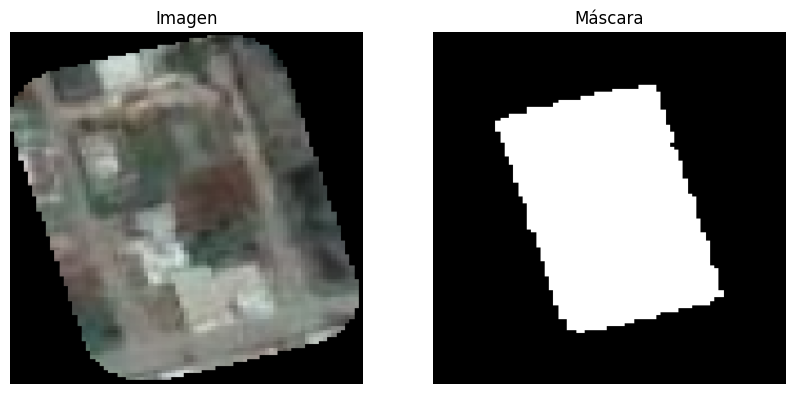

In [ ]:
import matplotlib.pyplot as plt

# Índice de la imagen y máscara que deseas graficar
indice = 1500

# Obtener la imagen y máscara correspondiente
image = images_entrenamiento_padded[indice]
mask = masks_entrenamiento_padded_umbral[indice]

# Crear una figura con dos ejes
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Graficar la imagen
axs[0].imshow(image)
axs[0].set_title('Imagen')
axs[0].axis('off')

# Graficar la máscara
axs[1].imshow(mask, cmap='gray')
axs[1].set_title('Máscara')
axs[1].axis('off')

plt.show()

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.models import Model

def create_unet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)

    # Decoder
    up5 = Conv2D(128, (2, 2), activation='relu', padding='same')(UpSampling2D((2, 2))(drop4))
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

    up6 = Conv2D(64, (2, 2), activation='relu', padding='same')(UpSampling2D((2, 2))(conv5))
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2D(32, (2, 2), activation='relu', padding='same')(UpSampling2D((2, 2))(conv6))
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)

    conv8 = Conv2D(1, (1, 1), activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=conv8)

    return model

input_shape = (*TARGET_SIZE, 3)
unet_model = create_unet(input_shape)

NameError: name 'TARGET_SIZE' is not defined

In [ ]:
# from tensorflow.keras.optimizers import Adam
# lr = 1e-4
# unet_model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['binary_accuracy'])
# unet_model.fit(images_entrenamiento_padded, masks_entrenamiento_padded_umbral, batch_size=BATCH_SIZE, epochs=EPOCAS, validation_split=0.2)

In [ ]:
from datetime import datetime
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

lr = 1e-4

unet_model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['binary_accuracy'])

# Obtener la fecha y hora actual
fecha_hora_actual = datetime.now().strftime("%Y%m%d_%H%M%S")

# Definir el nombre del archivo para guardar el modelo con la fecha y hora
nombre_archivo_modelo = f'/content/drive/MyDrive/ARTICULO/modelos/unet_model_{fecha_hora_actual}.h5'

# Crear un callback para guardar el mejor modelo durante el entrenamiento
checkpoint = ModelCheckpoint(nombre_archivo_modelo, monitor='val_loss', verbose=1, save_best_only=True)

# Entrenar el modelo y guardar el mejor
fit_history = unet_model.fit(images_entrenamiento_padded, masks_entrenamiento_padded_umbral, batch_size=BATCH_SIZE, epochs=EPOCAS
               , validation_split=0.2, callbacks=[checkpoint])

Epoch 1/20
69/69 [==============================] - ETA: 0s - loss: 0.4429 - binary_accuracy: 0.8076
Epoch 1: val_loss improved from inf to 0.32175, saving model to /content/drive/MyDrive/ARTICULO/modelos/unet_model_20240525_230623.h5
69/69 [==============================] - 467s 7s/step - loss: 0.4429 - binary_accuracy: 0.8076 - val_loss: 0.3217 - val_binary_accuracy: 0.9247
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - ETA: 0s - loss: 0.1792 - binary_accuracy: 0.9403
Epoch 2: val_loss improved from 0.32175 to 0.17505, saving model to /content/drive/MyDrive/ARTICULO/modelos/unet_model_20240525_230623.h5
69/69 [==============================] - 462s 7s/step - loss: 0.1792 - binary_accuracy: 0.9403 - val_loss: 0.1751 - val_binary_accuracy: 0.9322
Epoch 3/20
69/69 [==============================] - ETA: 0s - loss: 0.1327 - binary_accuracy: 0.9468
Epoch 3: val_loss improved from 0.17505 to 0.15625, saving model to /content/drive/MyDrive/ARTICULO/modelos/unet_model_20240525_230623.h5
69/69 [==============================] - 462s 7s/step - loss: 0.1327 - binary_accuracy: 0.9468 - val_loss: 0.1563 - val_binary_accuracy: 0.9363
Epoch 4/20
69/69 [==============================] - ETA: 0s - loss: 0.1239 - binary_accuracy: 0.9497
Epoch 4: val_loss did not improve from 0.15625
69/69 [==============================] - 460s 7s/step - loss: 0.1239 - binary_accuracy: 0.9497 - 

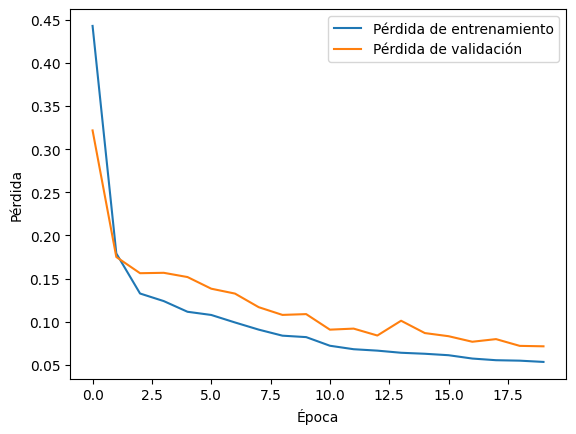

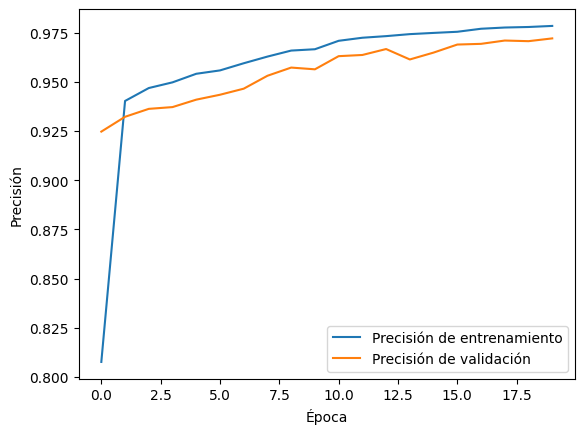

In [ ]:
import matplotlib.pyplot as plt

plt.plot(fit_history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(fit_history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

plt.plot(fit_history.history['binary_accuracy'], label='Precisión de entrenamiento')
plt.plot(fit_history.history['val_binary_accuracy'], label='Precisión de validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()


1/1 [==============================] - 0s 60ms/step


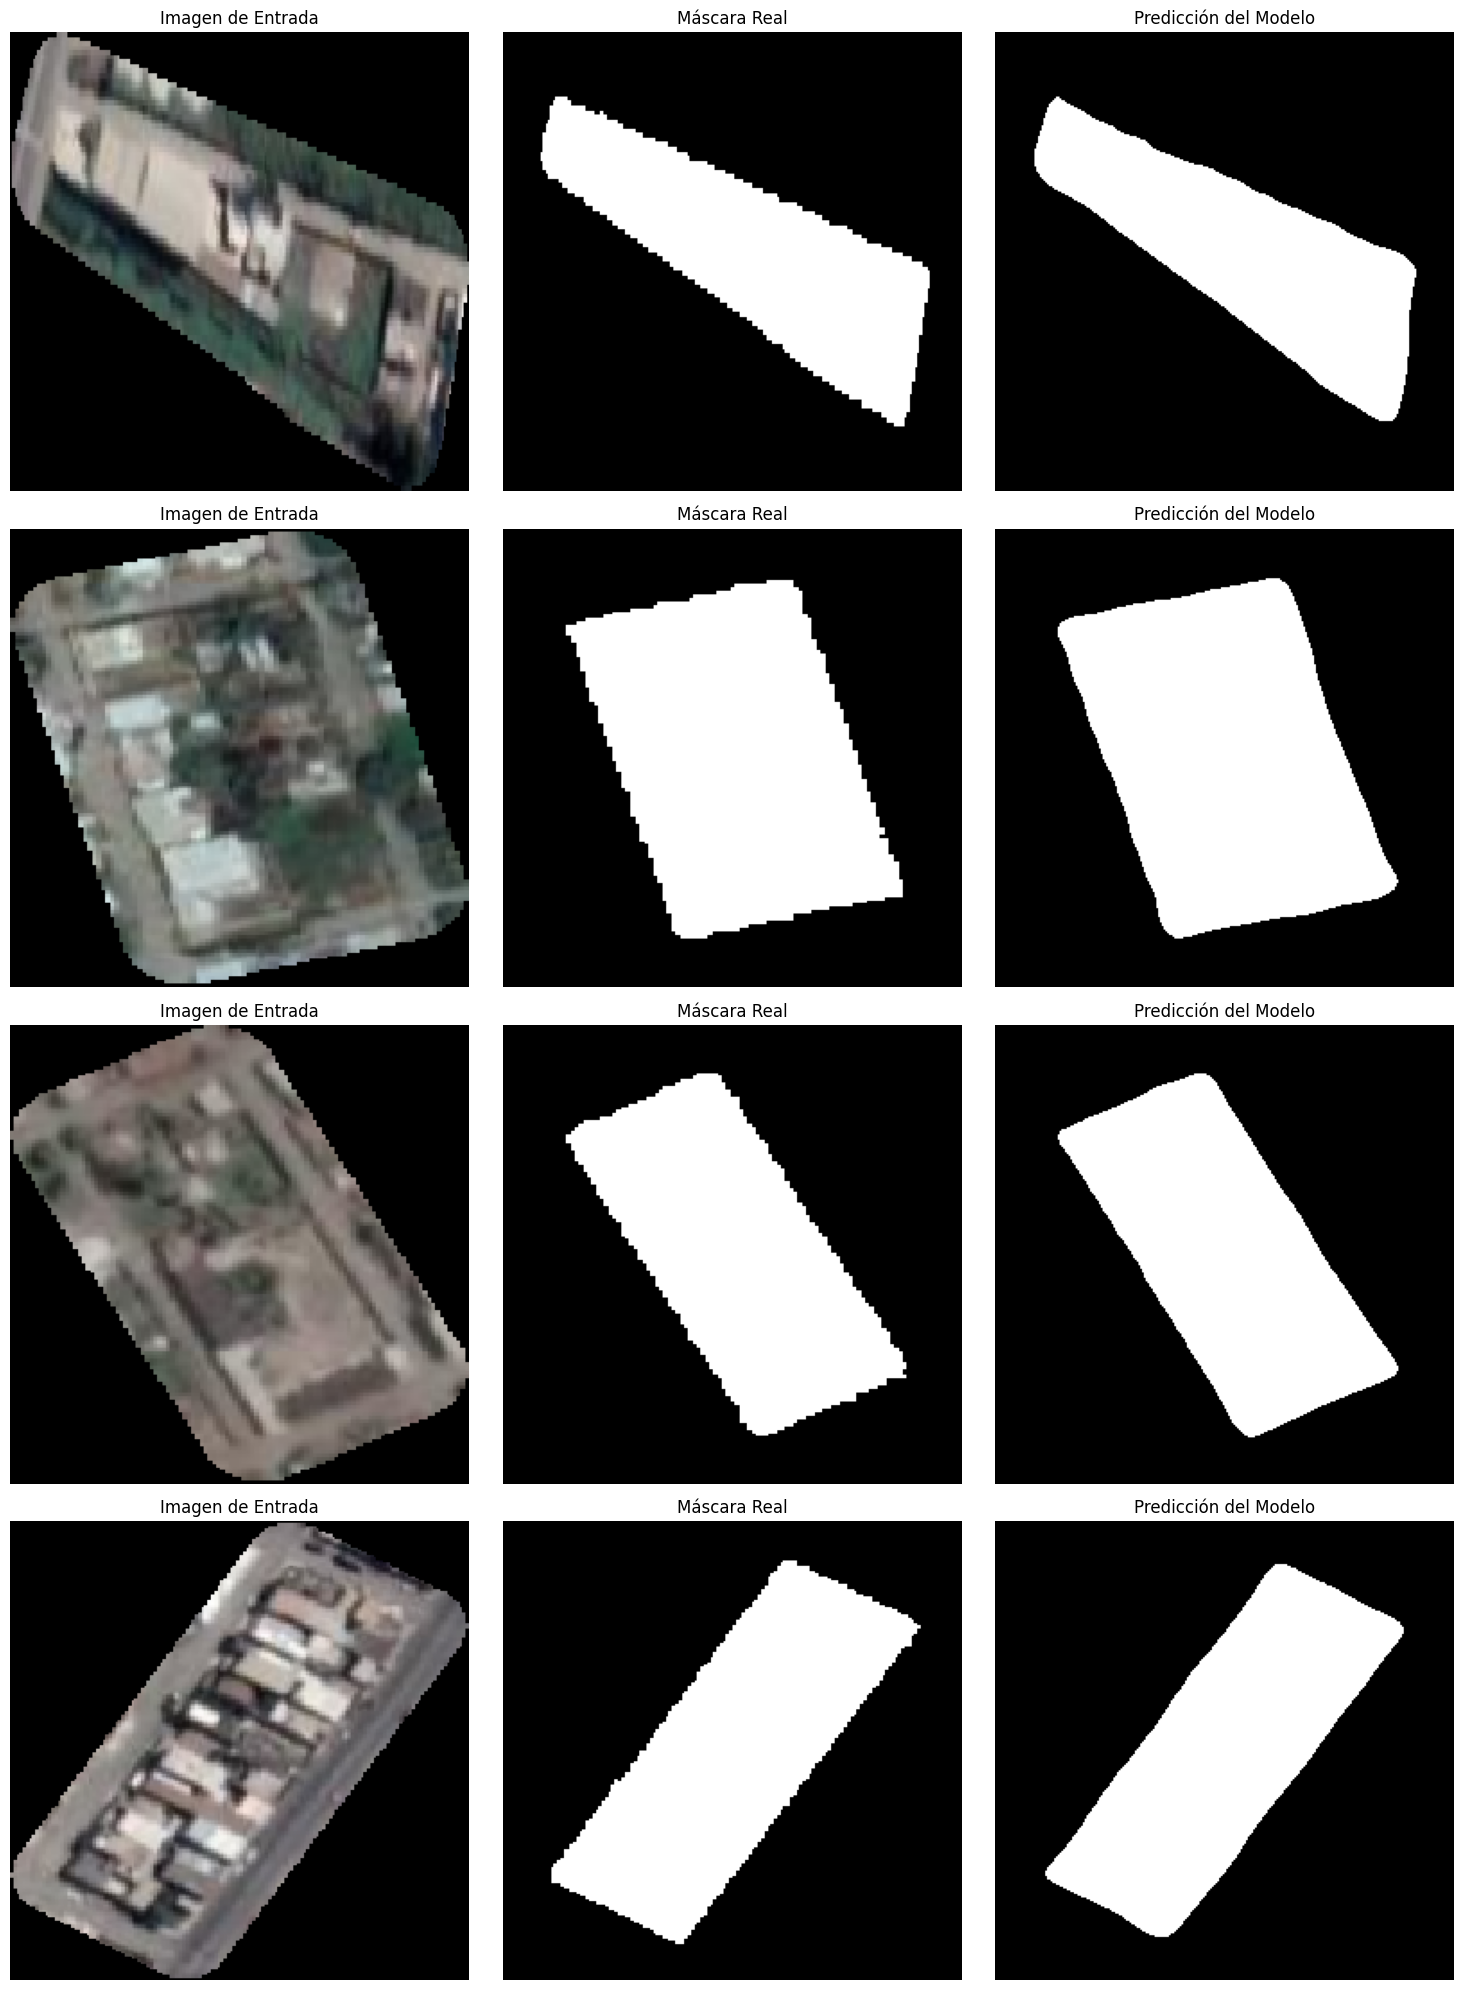

In [ ]:
import random
num_muestras = 4

total_imagenes = images_entrenamiento_padded.shape[0]

# Seleccionar índices aleatorios
indices_muestras = random.sample(range(total_imagenes), num_muestras)

# Crear una figura con subplots para la visualización
fig, axs = plt.subplots(num_muestras, 3, figsize=(15, 5 * num_muestras))

for i, indice in enumerate(indices_muestras):
    # Obtener la imagen de entrada, la máscara real y la predicción del modelo
    sample_image = images_entrenamiento_padded[indice]
    sample_mask = masks_entrenamiento_padded_umbral[indice]
    sample_prediction = unet_model.predict(np.expand_dims(sample_image, axis=0))[0]

    # Umbralizar la predicción del modelo si es necesario
    umbral = 0.5
    sample_prediction_thresholded = (sample_prediction > umbral).astype(np.uint8)

    # Mostrar la imagen de entrada
    axs[i, 0].imshow(sample_image, cmap='gray')
    axs[i, 0].set_title('Imagen de Entrada')
    axs[i, 0].axis('off')

    # Mostrar la máscara real
    axs[i, 1].imshow(sample_mask, cmap='gray')
    axs[i, 1].set_title('Máscara Real')
    axs[i, 1].axis('off')

    # Mostrar la predicción del modelo
    axs[i, 2].imshow(sample_prediction_thresholded, cmap='gray')
    axs[i, 2].set_title('Predicción del Modelo')
    axs[i, 2].axis('off')

# Mostrar la gráfica
plt.tight_layout()
plt.show()


86/86 [==============================] - 72s 840ms/step


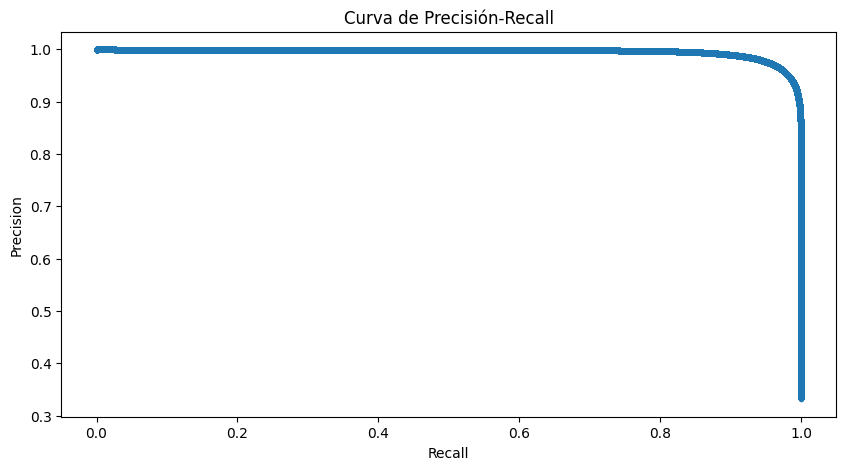

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Obtener las predicciones y etiquetas verdaderas en formato aplanado
y_true_flat = masks_entrenamiento_padded_umbral.ravel()
y_pred_flat = unet_model.predict(images_entrenamiento_padded).ravel()

# Calcular la curva de precisión-recall
precision, recall, _ = precision_recall_curve(y_true_flat, y_pred_flat)

plt.figure(figsize=(10, 5))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva de Precisión-Recall')
plt.show()


In [ ]:
# Convertir el historial de entrenamiento en un diccionario de arrays de NumPy
historial_dict = {key: np.array(value) for key, value in fit_history.history.items()}

# Guardar el diccionario en un archivo .npz
np.savez('/content/drive/MyDrive/ARTICULO/historial_entrenamiento.npz', **historial_dict)


In [ ]:
# Cargar el diccionario desde el archivo .npz
historial_cargado = np.load('/content/drive/MyDrive/ARTICULO/historial_entrenamiento.npz')

# Convertir el historial cargado a un formato que puedas usar para crear gráficos
historial_dict = {key: historial_cargado[key] for key in historial_cargado}

# Ahora puedes usar 'historial_dict' para crear gráficos o análisis


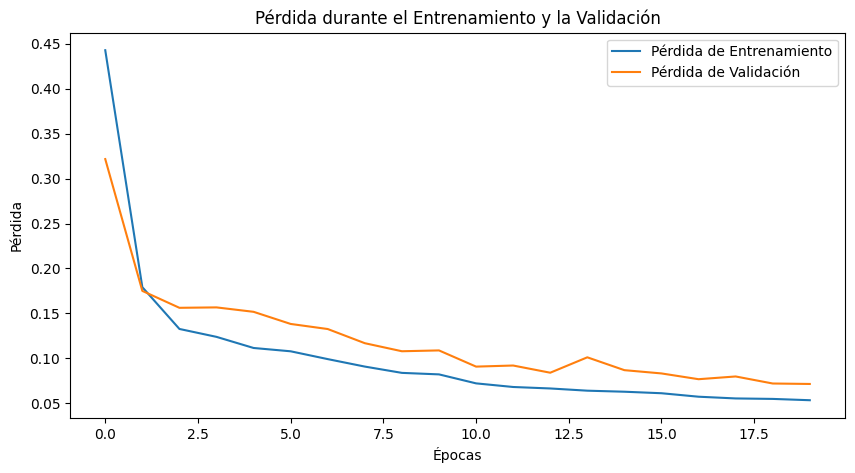

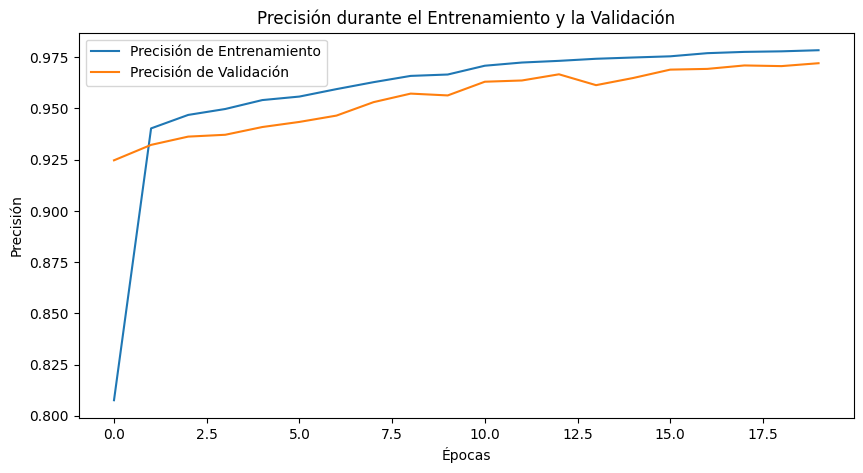

In [ ]:
import matplotlib.pyplot as plt

# Extraer los valores de pérdida y precisión del historial cargado
loss = historial_dict['loss']
val_loss = historial_dict['val_loss']
binary_accuracy = historial_dict['binary_accuracy']
val_binary_accuracy = historial_dict['val_binary_accuracy']

# Pérdida durante el entrenamiento y la validación
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Pérdida de Entrenamiento')
plt.plot(val_loss, label='Pérdida de Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida durante el Entrenamiento y la Validación')
plt.legend()
plt.show()

# Precisión durante el entrenamiento y la validación
plt.figure(figsize=(10, 5))
plt.plot(binary_accuracy, label='Precisión de Entrenamiento')
plt.plot(val_binary_accuracy, label='Precisión de Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión durante el Entrenamiento y la Validación')
plt.legend()
plt.show()
